# 1.简介

该部分将对基本的**几何变换**进行学习，几何变换的原理大多都是相似，只是变换矩阵不同，因此，我们以最常用的平移和旋转为例进行学习。在深度学习领域，我们常用平移、旋转、镜像等操作进行**数据增广**；在传统CV领域，由于某些拍摄角度的问题，我们需要对图像进行**矫正处理**，而几何变换正是这个处理过程的基础，因此了解和学习几何变换也是有必要的。

这次我们带着几个问题进行，以旋转为例：

- 变换的形式（公式）是什么？
- 旋转中心是什么？毕竟以不同位置为旋转中心得到的结果是不一样的。
- 采用前向映射还是反向映射？(反向映射更为有效)
- 采用反向映射后，采用何种插值算法？最常用的的是双线性插值，OpenCV也是默认如此。

# 2.学习目标
- 了解几何变换的概念与应用
- 理解平移、旋转的原理
- 掌握在OpenCV框架下实现平移、旋转操作

# 3.算法原理介绍
## 变换的形式
这里采取冈萨雷斯的《数字图像处理_第三版》的变换矩阵方式，关于OpenCV的策略可以看它的官方文档。根据冈萨雷斯书中的描述，仿射变换的一般形式如下：
$$\left[ \begin{matrix} x & y & 1\end{matrix} \right]=\left[ \begin{matrix} v & w & 1\end{matrix} \right]T=\left[ \begin{matrix} v & w & 1\end{matrix} \right]\left[ \begin{matrix} t_11 & t_12 & 0 \\ t_21 &t_22&0\\t_31&t_32&1 \end{matrix} \right]$$

式中的T就是变换矩阵，其中 (v,w)为原坐标，(x,y) 为变换后的坐标，不同的变换对应不同的矩阵。

一些常见的变换矩阵及作用如下：
![avatar](常见变换矩阵.png)
在使用过程中可以根据自己的目的选择不同变换

## 坐标系变换

### 变换中心
对于缩放、平移可以以图像坐标原点（图像左上角为原点）为中心变换，这不用坐标系变换，直接按照一般形式计算即可。而对于旋转和偏移，一般是以图像中心为原点，那么这就涉及坐标系转换了。
数学课本中常见的坐标系是以图像中心为原点，水平向右为 X 轴，垂直向上为 Y 轴，称为笛卡尔坐标系。看下图:
![avatar](坐标系.png)
因此，对于旋转和偏移，就需要3步（3次变换）：
- 将输入原图像坐标转换为笛卡尔坐标系
- 进行旋转计算
- 将旋转后的图像的笛卡尔坐标转回图像坐标

### 图像坐标系与笛卡尔坐标系转换关系
![avatar](笛卡尔坐标系与图像坐标系.png)
如图所示，在图像坐标系中，原点为A，方向为AB和AC；在笛卡尔坐标系中，原点为D,方向为DE和DF方向。假设图像为$ m\times n$，对于A点，在图像坐标系中坐标为(0,0)，在笛卡尔坐标系中，坐标为$(\frac{-N}{2},\frac{M}{2})$，因此，图像中某像素点$(x',y')$转换为笛卡尔坐标系(x,y)关系如下：
$$x=x'-\frac{-N}{2},y=-y'+\frac{M}{2}$$
根据3次变换，旋转(顺时针旋转)的变换形式，3次变换就有3个矩阵
$$\left[ \begin{matrix} x & y & 1\end{matrix} \right]=\left[ \begin{matrix} x' & y' & 1\end{matrix} \right]T=\left[ \begin{matrix} x' & y' & 1\end{matrix} \right]\left[ \begin{matrix} 1 & 0 & 0 \\ 0 &-1&0\\-0.5\times N&0.5 \times M&1 \end{matrix} \right]\left[ \begin{matrix} cos(\theta) & -sin(\theta) & 0 \\ sin(\theta) &cos(\theta)&0\\0&0&1 \end{matrix} \right]\left[ \begin{matrix} 1 & 0 & 0 \\ 0 &-1&0\\-0.5\times N&0.5 \times M&1 \end{matrix} \right]$$

## 映射方法
### 向前映射法
可以将几何运算想象成一次一个象素地转移到输出图象中。如果一个输入象素被映射到四个输出象素之间的位置，则其灰度值就按插值算法在4个输出象素之间进行分配。称为向前映射法，或象素移交影射。
> 注：从原图象坐标计算出目标图象坐标镜像、平移变换使用这种计算方法
### 向后映射法
向后映射法（或象素填充算法）是输出象素一次一个地映射回到输入象素中，以便确定其灰度级。如果一个输出象素被映射到4个输入象素之间，则其灰度值插值决定，向后空间变换是向前变换的逆。
> 注：从结果图象的坐标计算原图象的坐标;旋转、拉伸、放缩可以使用;解决了漏点的问题，出现了马赛克

在冈萨雷斯的《数字图像处理_第三版》中说的很清楚，前向映射就是根据原图用变换公式直接算出输出图像相应像素的空间位置，那么这会导致一个问题：可能会有多个像素坐标映射到输出图像的同一位置，也可能输出图像的某些位置完全没有相应的输入图像像素与它匹配，也就是没有被映射到，造成有规律的空洞（黑色的蜂窝状）。更好的一种方式是采用 反向映射（Inverse Mapping）：扫描输出图像的位置(x,y)，通过$$\left[ \begin{matrix} v & w & 1\end{matrix} \right]=\left[ \begin{matrix} x & y & 1\end{matrix} \right]T^{-1}$$计算输入图像对应的位置 (v,w)，通过插值方法决定输出图像该位置的灰度值。

## 插值
采用反向映射后，需通过插值方法决定输出图像该位置的值，因此需要选择插值算法。通常有最近邻插值、双线性插值，双三次插值等，OpencV默认采用双线性插值，我们也就采用双线性插值

# 4.基于OpenCV的实现
- 工具：Jupyter notebook(python3.7)
- 平台：MacOS10.14.6
## 平移变换
warpAffine()

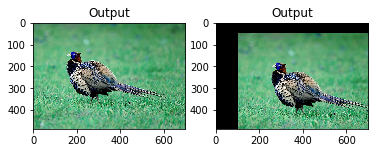

In [4]:
import cv2
import numpy as np

img=cv2.imread('imag.jpeg')

row,col,channnel=img.shape
#warpAffine()接受三个参数，分别为原图像，变换矩阵，变换后大小
M=np.float32([[1,0,100],[0,1,50]])
dst=cv2.warpAffine(img,M,(col,row))

plt.subplot(121),plt.imshow(img),plt.title('Output')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

## 旋转变换
getRotationMatrix2D(center,angle,scale)
- center : 旋转中心
- angle : 旋转角度
- scale : 缩放比例

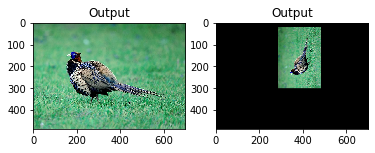

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img=cv2.imread('imag.jpeg',1)
row,col,channel=img.shape

M=cv2.getRotationMatrix2D((col/2,row/3),90,0.4)
dst=cv2.warpAffine(img,M,(col,row))

plt.subplot(121),plt.imshow(img),plt.title('Output')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

## 仿射变换
仿射变换是一种二维坐标到二维坐标之间的线性变换，并保持二维图形的“平直性”。转换前平行的线，在转换后依然平行。

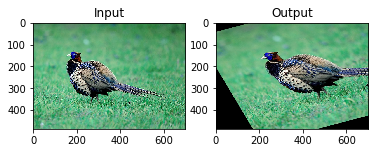

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img=cv2.imread('imag.jpeg',1)
row,col,channel=img.shape

pts1=np.float32([[50,50],[200,50],[50,200]])
pts2=np.float32([[10,100],[200,50],[100,250]])

M=cv2.getAffineTransform(pts1,pts2)

dst=cv2.warpAffine(img,M,(col,row))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

## 透视变换
透视变换是将图片投影到一个新的视平面，也称作投影映射。它是二维（x,y）到三维(X,Y,Z)，再到另一个二维(x’,y’)空间的映射。相对于仿射变换，它提供了更大的灵活性，将一个四边形区域映射到另一个四边形区域（不一定是平行四边形）。透视变换需要3×3的变换矩阵，直线在变换后还是保持直线。为了构造变换矩阵，你需要输入图像的4个点和对应的要输出图像的4个点；要求这4个点其中3个点不共线。使用cv2.getPerspectiveTransform函数构造透视变换矩阵。

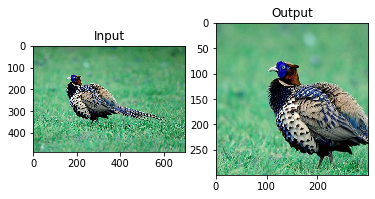

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img=cv2.imread('imag.jpeg',1)
row,col,channel,img.shape

pts1=np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2=np.float32([[0,0],[300,0],[0,300],[300,300]])

M=cv2.getPerspectiveTransform(pts1,pts2)
dst=cv2.warpPerspective(img,M,(300,300))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

# 参考博客
- https://github.com/datawhalechina/team-learning/blob/master/%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%A7%86%E8%A7%89%E5%9F%BA%E7%A1%80%EF%BC%9A%E5%9B%BE%E5%83%8F%E5%A4%84%E7%90%86%EF%BC%88%E4%B8%8A%EF%BC%89/Task02%20%E5%87%A0%E4%BD%95%E5%8F%98%E6%8D%A2.md
- https://blog.csdn.net/g11d111/article/details/79978582